In [1]:
# Import libraries
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt


import unicodedata
import re
import string
import joblib as joblib
import pickle as pickle

In [2]:
# nltk.download('punkt')
# pip install unidecode
from unidecode import unidecode

In [3]:
# Load data
data_train = pd.read_csv('../../Data Splits/train_data_60_40.csv')
data_val = pd.read_csv('../../Data Splits/val_data_60_40.csv')

In [4]:
X_train = data_train['article']
y_train = data_train['label']

X_val = data_val['article']
y_val = data_val['label']

In [5]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [self.preprocess(text) for text in X]

    def preprocess(self, text):
        # print(textes)
        text = str(text)
        text = text.lower()
        normalized = unicodedata.normalize("NFD", text)
        text = "".join(c for c in normalized if unicodedata.category(c) != "Mn")
        text = re.sub(r'\[.*?\]', '', text)
        text = re.sub(r"\\W", " ", text)
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        text = re.sub(r'<.*?>+', '', text)
        text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
        text = re.sub(r'\n', '', text)
        text = re.sub(r'\w*\d\w*', '', text)
        return text

In [6]:
#create StopWords
stopwords = pd.read_json('../../Datasets/stopwords-tl.json')
custom_stop_words = stopwords[0].values.tolist()

In [7]:
# Initializing base models

mnb = MultinomialNB()
lr = LogisticRegression()
rf = RandomForestClassifier()
knn = KNeighborsClassifier()
svm = SVC(probability=True)

base_models = [mnb, lr, rf, knn, svm]
base_names = ['MNB', 'LR', 'RF', 'KNN', 'SVM']


Metrics for MNB:
Accuracy: 0.8362218370883883
Precision: 0.7628726287262872
Recall: 0.975736568457539
F1 Score: 0.8562737642585552
AUC: 0.9723394477501208
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.70      0.81       577
           1       0.76      0.98      0.86       577

    accuracy                           0.84      1154
   macro avg       0.86      0.84      0.83      1154
weighted avg       0.86      0.84      0.83      1154



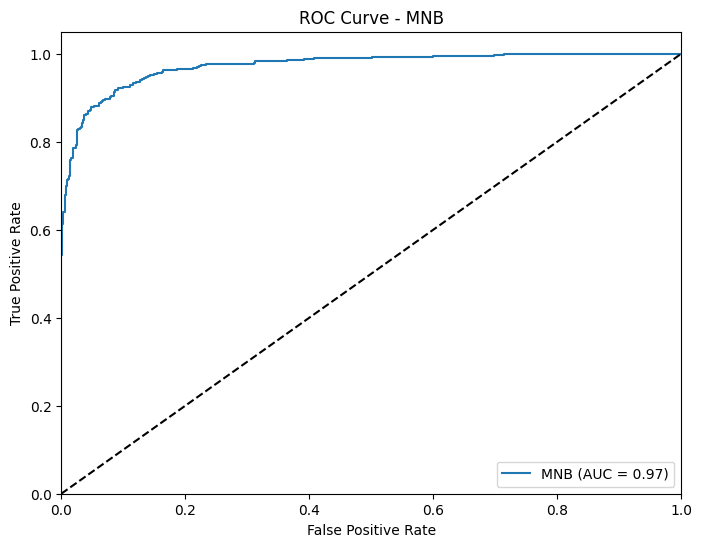

Metrics for LR:
Accuracy: 0.9324090121317158
Precision: 0.9544626593806922
Recall: 0.9081455805892548
F1 Score: 0.9307282415630551
AUC: 0.9827951304932884
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       577
           1       0.95      0.91      0.93       577

    accuracy                           0.93      1154
   macro avg       0.93      0.93      0.93      1154
weighted avg       0.93      0.93      0.93      1154



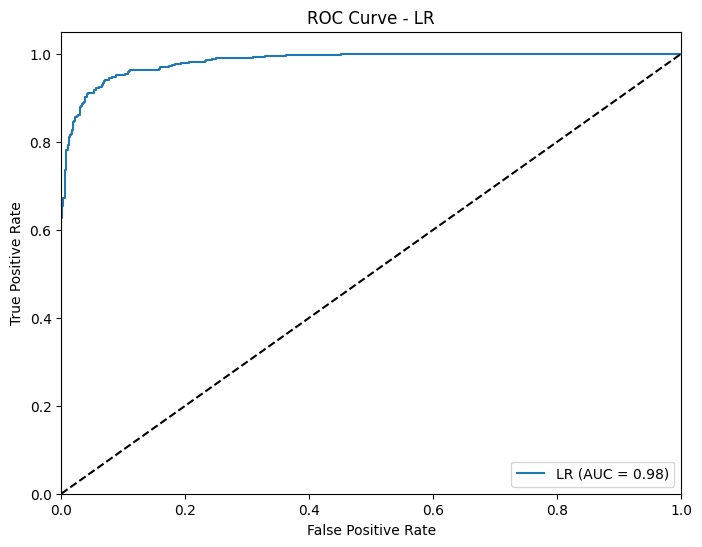

Metrics for RF:
Accuracy: 0.9350086655112652
Precision: 0.9357638888888888
Recall: 0.9341421143847487
F1 Score: 0.9349522983521249
AUC: 0.983242673362789
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       577
           1       0.94      0.93      0.93       577

    accuracy                           0.94      1154
   macro avg       0.94      0.94      0.94      1154
weighted avg       0.94      0.94      0.94      1154



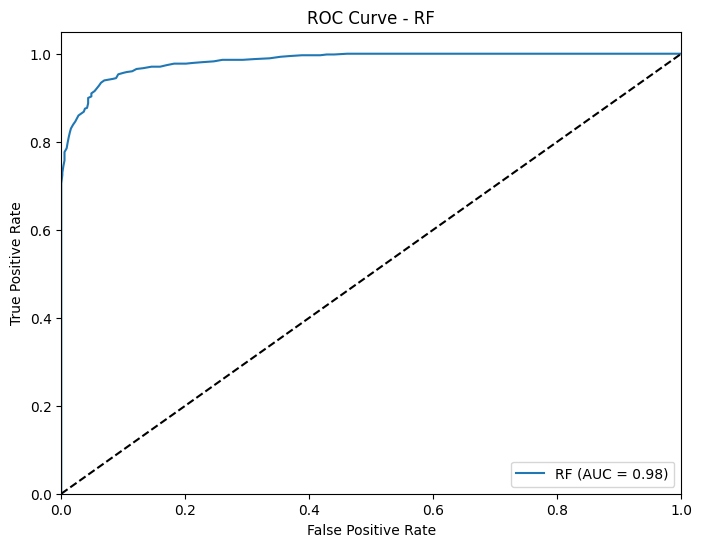

Metrics for KNN:
Accuracy: 0.8570190641247833
Precision: 0.8056379821958457
Recall: 0.9410745233968805
F1 Score: 0.86810551558753
AUC: 0.9440135884828298
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.77      0.84       577
           1       0.81      0.94      0.87       577

    accuracy                           0.86      1154
   macro avg       0.87      0.86      0.86      1154
weighted avg       0.87      0.86      0.86      1154



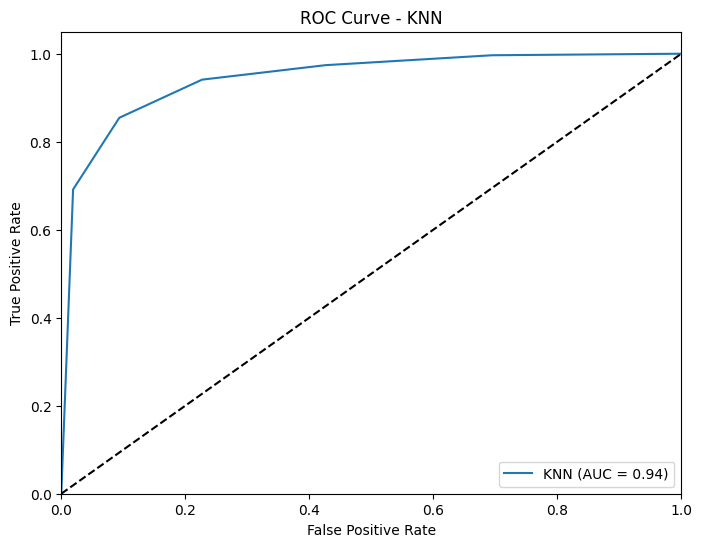

Metrics for SVM:
Accuracy: 0.9402079722703639
Precision: 0.9652014652014652
Recall: 0.9133448873483535
F1 Score: 0.9385574354407836
AUC: 0.9877586512439589
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       577
           1       0.97      0.91      0.94       577

    accuracy                           0.94      1154
   macro avg       0.94      0.94      0.94      1154
weighted avg       0.94      0.94      0.94      1154



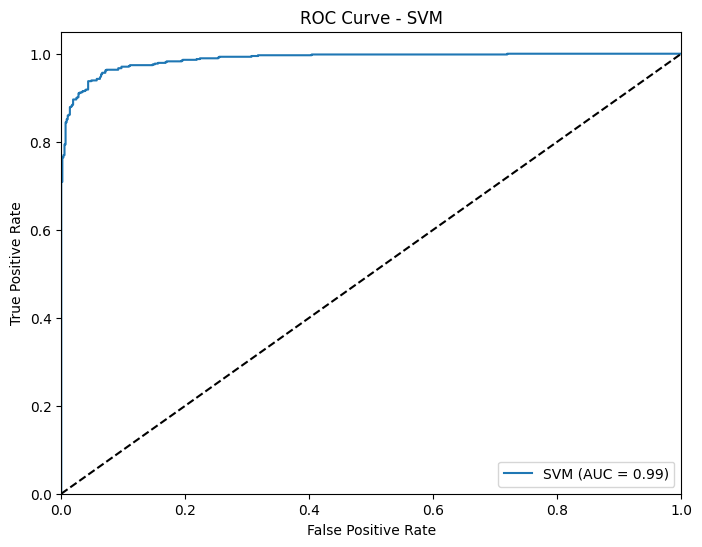

In [12]:
stack = joblib.load('../../Models/60-40 Test/pipeline_svm.joblib')

# Create an empty DataFrame for storing metrics
metrics_df = pd.DataFrame(index=base_names + ['Stacking Model'], columns=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])

# Use TFIDF inside of stacking to vectorize X_val(Evaluation)
vectorized_text = stack.named_steps['vectorizer'].transform(X_val)

# Evaluate base models
for model, name in  zip(stack.named_steps['stacking'].estimators_ , base_names):
    y_pred = model.predict(vectorized_text)
    y_prob = model.predict_proba(vectorized_text)[:, 1]  # Probability for positive class for ROC curve
    
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_prob)

    print(f"Metrics for {name}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"AUC: {auc}")
    print(f"Classification Report:\n{classification_report(y_val, y_pred)}")

    # Store metrics in the DataFrame
    metrics_df.loc[name] = [accuracy, precision, recall, f1, auc]

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    roc_auc = roc_auc_score(y_val, y_prob)

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc="lower right")
    plt.show()

Metrics for Stacking Model:
Accuracy: 0.9480069324090121
Precision: 0.9449225473321858
Recall: 0.951473136915078
F1 Score: 0.9481865284974094
AUC: 0.9875619125999838
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       577
           1       0.94      0.95      0.95       577

    accuracy                           0.95      1154
   macro avg       0.95      0.95      0.95      1154
weighted avg       0.95      0.95      0.95      1154



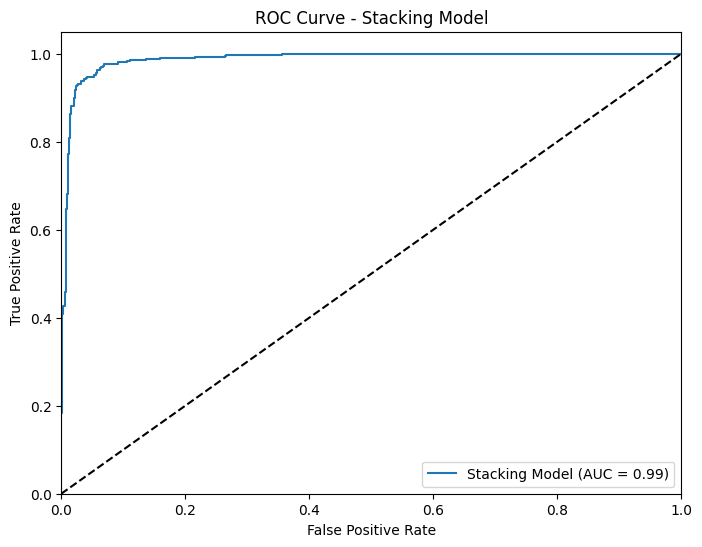

Comparison of Models:
                Accuracy Precision    Recall  F1 Score       AUC
MNB             0.836222  0.762873  0.975737  0.856274  0.972339
LR              0.932409  0.954463  0.908146  0.930728  0.982795
RF              0.935009  0.935764  0.934142  0.934952  0.983243
KNN             0.857019  0.805638  0.941075  0.868106  0.944014
SVM             0.940208  0.965201  0.913345  0.938557  0.987759
Stacking Model  0.948007  0.944923  0.951473  0.948187  0.987562


In [13]:
# Evaluate stacking model
stack_y_pred = stack.predict(X_val)
stack_y_prob = stack.predict_proba(X_val)[:, 1]  # Probability for positive class for ROC curve

stack_accuracy = accuracy_score(y_val, stack_y_pred)
stack_precision = precision_score(y_val, stack_y_pred)
stack_recall = recall_score(y_val, stack_y_pred)
stack_f1 = f1_score(y_val, stack_y_pred)
stack_auc = roc_auc_score(y_val, stack_y_prob)

print("Metrics for Stacking Model:")
print(f"Accuracy: {stack_accuracy}")
print(f"Precision: {stack_precision}")
print(f"Recall: {stack_recall}")
print(f"F1 Score: {stack_f1}")
print(f"AUC: {stack_auc}")
print(f"Classification Report:\n{classification_report(y_val, stack_y_pred)}")

# ROC Curve for stacking model
stack_fpr, stack_tpr, _ = roc_curve(y_val, stack_y_prob)
stack_roc_auc = roc_auc_score(y_val, stack_y_prob)

# Store stacking model metrics in the DataFrame
metrics_df.loc['Stacking Model'] = [stack_accuracy, stack_precision, stack_recall, stack_f1, stack_auc]


# Plot ROC Curve for stacking model
plt.figure(figsize=(8, 6))
plt.plot(stack_fpr, stack_tpr, label=f'Stacking Model (AUC = {stack_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Stacking Model')
plt.legend(loc="lower right")
plt.show()

# Display the comparison table
print("Comparison of Models:")
print(metrics_df)